In [177]:
import os #
import random #
import numpy as np #
import pandas as pd #
import multiprocessing as mp #

In [3]:
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*2)/10000)

In [78]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [79]:
%%R
library(ggplot2)
library(RColorBrewer)
library(ggbeeswarm)
library(ggpubr)

In [27]:
#-----import public clones-----
pool_AB_=pd.read_csv("/projects/fmba_covid/adaptive_new/pool/pool.aa.table.20+.txt", sep = '\t') 
pool_FMBA_=pd.read_csv("/projects/fmba_covid/fmba_new/pool/TRB.pool.aa.table.txt", sep = '\t') 

In [315]:
pool_AB=pool_AB_.loc[pool_AB_.incidence>350]
pool_FMBA=pool_FMBA_.loc[pool_FMBA_.incidence>25]

In [316]:
#-----filter out bed clones-----
pool_filter_AB=[x for x in list(pool_AB.cdr3aa) if ('_' or '*' or '~')  not in str(x)] 
pool_filter_AB=[x for x in  list(pool_AB.cdr3aa) if  len(x)>=9 and len(x)<=17]
pool_filter_FMBA=[x for x in  list(pool_FMBA.cdr3aa) if ('_' or '*' or '~')  not in str(x)]
pool_filter_FMBA=[x for x in  list(pool_FMBA.cdr3aa) if  len(x)>=9 and len(x)<=17]
print('lenght_pool_AB:', len(pool_filter_AB))
print('lenght_pool_FMBA:', len(pool_filter_FMBA))

lenght_pool_AB: 19516
lenght_pool_FMBA: 8926


In [317]:
pool_filter=set(pool_filter_AB)|set(pool_filter_FMBA)
print('lenght_pool:', len(pool_filter))

lenght_pool: 19965


In [30]:
pool_filter_random=random.sample(pool_filter, 50000)

In [37]:
#-----merge groups of V segments-----
def merge_V_groups(TRBV):
    if "-" in TRBV:
        TRBV=TRBV[:TRBV.rfind('-')]
    return TRBV           

#-----pool_FMBA-----
pool_FMBA_v=list(map(merge_V_groups, list(pool_FMBA.v)))
#-----create clone and V-segment correspondence dictionaries-----
dct_pool_v=dict(zip(list(pool_FMBA.cdr3aa), list(pool_FMBA_v)))
dct_accosiated_clones_v={x:dct_pool_v[x] for x in pool_filter_FMBA}
#-----create a strings with CDR3aa and V-segments delimited by "@"-----
pool_FMBA_v=list(map(lambda x: x+f'@{dct_accosiated_clones_v[x]}', pool_filter_FMBA))

In [100]:
def hamming_distance(clone1, clone2):
    return sum(c1 != c2 for c1, c2 in zip(clone1, clone2))

In [10]:
def get_clonotypes_frequences_hamming1_Vsegment(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------make a dictionary, initialize by all zeroes-----
    local_clonesV_in_samples=dict([(xT,0) for xT in clones_for_analyse])
#------read clonotype tabel-----    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.strip().split("\t")
            total_counts+=1 #clone count
#------zero or one mismatch is amino acid CDR3aa sequence------
            for cloneV_of_interest in local_clonesV_in_samples:
                clone_of_interest=cloneV_of_interest[:cloneV_of_interest.rfind('@')]
                v_of_interest=cloneV_of_interest[cloneV_of_interest.rfind('@')+1:]
                if len(clone_of_interest)==len(clone[0]): 
                    if hamming_distance(clone_of_interest, clone[0])<=1 and v_of_interest==clone[4]:
                        local_clonesV_in_samples[cloneV_of_interest]+=float(clone[2])         
        return (sample_name, local_clonesV_in_samples)           

In [303]:
#-----calculate the weight of the clone in the sample with the possibility of one mismatch-----

def get_clonotypes_frequences_hamming(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.split()
#------zero or one mismatch (clone[0] is amino acid CDR3 sequence)------
            for clone_of_interest in local_clones_in_samples:
                if len(clone_of_interest)==len(clone[0]): 
                    if hamming_distance(clone_of_interest, clone[0])<=1: 
                        local_clones_in_samples[clone_of_interest]+=1
        return (sample_name, local_clones_in_samples)
    
#freq: clone[1] - full data    
#      clone[3] - top 5000AA 

In [258]:
#-----calculate the weight of the clone in the sample-----

def get_clonotypes_frequences(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------    
    clonotype_file=pd.read_csv(str(path_to_folder_with_sample)+"/"+str(sample_name), sep='\t', index_col=0)
#------complete sequence match------    
    sample_clones=clonotype_file.index
    sample_public=set(clones_for_analyse)&set(sample_clones)
    sample_public_freq=clonotype_file.loc[sample_public, "freq"].to_dict() 
    local_clones_in_samples.update(sample_public_freq) 
    return (sample_name, local_clones_in_samples)

In [47]:
#-----calculate the weight of the clone in the sample-----

def get_clonotypes_unweighted(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------    
    clonotype_file=pd.read_csv(str(path_to_folder_with_sample)+"/"+str(sample_name), sep='\t', index_col=3)
#------complete sequence match------    
    sample_clones=clonotype_file.index
    sample_public=list(set(clones_for_analyse)&set(sample_clones))
    sample_public_unw=dict(zip(sample_public, [1]*len(sample_public)))
    local_clones_in_samples.update(sample_public_unw) 
    return (sample_name, local_clones_in_samples)

In [ ]:
%%time
folder_with_samples="../../random_forest_v4_top/DOWNSAMPLING_TOP_5000/VIP_07_top_5000AA" 
output_folder="FREQ_TABLES/VIP_07_top_5000AA"
output_file_name=output_folder+"/"+"VIP_07_public_FMBA.tsv"
public_clones=pool_filter_FMBA

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count())) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones]))  

FREQ_TABLES/VIP_07_top_5000AA
START


In [318]:
%%time
folder_with_samples="../../filter_out_private_clones/DOWNSAMPLING_TOP_PUBLIC_2000_v2/FMBA_top_2000AA" 
output_folder="UNWEIGHT_TABLES/FMBA/FMBA_top_public_2000AA"
output_file_name=output_folder+"/"+"FMBA_public_top_20000.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 10)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

#-----play a sound when the cell is finished-----
#Audio(wave, rate=10000, autoplay=True)            

UNWEIGHT_TABLES/FMBA/FMBA_top_public_2000AA
START
DONE
CPU times: user 52.2 s, sys: 3min 21s, total: 4min 13s
Wall time: 19min 46s


In [319]:
%%time
folder_with_samples="../../filter_out_private_clones/DOWNSAMPLING_TOP_PUBLIC_2000_v2/HIP_top_2000AA" 
output_folder="UNWEIGHT_TABLES/HIP/HIP_top_public_2000AA"
output_file_name=output_folder+"/"+"HIP_public_top_20000.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 10)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

#-----play a sound when the cell is finished-----
#Audio(wave, rate=10000, autoplay=True)            

UNWEIGHT_TABLES/HIP/HIP_top_public_2000AA
START
DONE
CPU times: user 42.6 s, sys: 2min 45s, total: 3min 28s
Wall time: 15min 39s


In [320]:
%%time
folder_with_samples="../../filter_out_private_clones/DOWNSAMPLING_TOP_PUBLIC_2000_v2/KECK_top_2000AA" 
output_folder="UNWEIGHT_TABLES/KECK/KECK_top_public_2000AA"
output_file_name=output_folder+"/"+"KECK_top_public_20000.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 10)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

#-----play a sound when the cell is finished-----
#Audio(wave, rate=10000, autoplay=True)            

UNWEIGHT_TABLES/KECK/KECK_top_public_2000AA
START
DONE
CPU times: user 9.05 s, sys: 42.5 s, total: 51.6 s
Wall time: 3min 4s


In [321]:
%%time
folder_with_samples="../../filter_out_private_clones/DOWNSAMPLING_TOP_PUBLIC_2000_v2/Adaptive_top_2000AA" 
output_folder="UNWEIGHT_TABLES/Adaptive/Adaptive_top_public_2000AA/"
output_file_name=output_folder+"/"+"Adaptive_public_top_20000.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 10)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

#-----play a sound when the cell is finished-----
#Audio(wave, rate=10000, autoplay=True)            

UNWEIGHT_TABLES/Adaptive/Adaptive_top_public_2000AA/
START
DONE
CPU times: user 1min 3s, sys: 4min 9s, total: 5min 13s
Wall time: 23min 33s


In [126]:
#-----read FMBA metadata------
FMBA_metadata=pd.read_csv("../../fmba/fmba_metadata_edited.tsv",
                          sep=",",header=0, dtype = str)
print("FMBA_metadata \n", FMBA_metadata.COVID_status.value_counts())

#-----read Adaptive metadata------
AB_metadata=pd.read_csv("../../adaptive/adaptive-metadata-edited.tsv",sep="\t")
AB_metadata["sample_short_name"]=AB_metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
print("\nAdaptive_metadata \n", AB_metadata["COVID-19-status"].value_counts())

FMBA_metadata 
 COVID       1061
healthy      433
precovid     118
unknown       27
Name: COVID_status, dtype: int64

Adaptive_metadata 
 acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64


In [127]:
#----select FMBA cohorts-----
fmba_IgM_pos = set(FMBA_metadata.loc[FMBA_metadata['COVID_IgM']=='yes', "name"])
print("fmba_IgM_pos:", len(fmba_IgM_pos))
fmba_IgM_neg_IgG_pos = set(FMBA_metadata.loc[(FMBA_metadata['COVID_IgM']=='no')&((FMBA_metadata['COVID_IgG']=='yes')), "name"])
print("fmba_IgM_neg_IgG_pos:", len(fmba_IgM_neg_IgG_pos))
fmba_PCR=set(FMBA_metadata.loc[FMBA_metadata['COVID_PCR']=='positive', "name"])
print("fmba_PCR:", len(fmba_PCR))
fmba_COVID=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='COVID', "name"])
print("fmba_COVID:", len(fmba_COVID))
fmba_healthy=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='healthy', "name"])
print("fmba_healthy:", len(fmba_healthy))
fmba_precovid=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='precovid', "name"])
print("fmba_precovid:", len(fmba_precovid))

#----select Adaptive cohorts-----
adaptive_acute=set(AB_metadata.loc[AB_metadata["COVID-19-status"]=="acute","sample_short_name"])
print("\nAdaptive_acute:",  len(adaptive_acute))

fmba_IgM_pos: 525
fmba_IgM_neg_IgG_pos: 432
fmba_PCR: 39
fmba_COVID: 1061
fmba_healthy: 433
fmba_precovid: 118

Adaptive_acute: 1140


In [337]:
COVID_associated_clones=pd.read_csv("WILCOX_TEST_RESULTS/UNWEIGHT/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_public_top_20000.tsv", sep="\t")
COVID_associated_clones=list(COVID_associated_clones.feature)
COVID_associated_clones=list(filter(lambda clone: len(clone)>9 and len(clone)<17, COVID_associated_clones))
print("COVID_associated_clones:", len(COVID_associated_clones))

COVID_associated_clones: 5446


In [338]:
%%time
#-----read Adaptive and HIP data-----
AB_data=pd.read_csv("UNWEIGHT_TABLES/Adaptive/Adaptive_top_public_2000AA/Adaptive_public_top_10000.tsv",
                    sep="\t")
AB_data.index=[xT.split("_")[0] for xT in AB_data.index]
AB_data[COVID_associated_clones].to_csv("UNWEIGHT_TABLES/Adaptive/Adaptive_top_public_2000AA/Adaptive_COVID_marker.tsv", sep="\t")

HIP_data=pd.read_csv("UNWEIGHT_TABLES/HIP/HIP_top_public_2000AA/HIP_public_top_20000.tsv",
                    sep="\t")
HIP_data.index=[xT.split(".")[0] for xT in HIP_data.index]
HIP_data[COVID_associated_clones].to_csv("UNWEIGHT_TABLES/HIP/HIP_top_public_2000AA/HIP_COVID_markers.tsv", sep="\t")

KECK_data=pd.read_csv("UNWEIGHT_TABLES/KECK/KECK_top_public_2000AA/KECK_top_public_20000.tsv",
                    sep="\t")
KECK_data.index=[xT.split("_")[0] for xT in KECK_data.index]
KECK_data[COVID_associated_clones].to_csv("UNWEIGHT_TABLES/KECK/KECK_top_public_2000AA/KECK_COVID_markers.tsv", sep="\t")

#----read FMBA data------
FMBA_data=pd.read_csv("UNWEIGHT_TABLES/FMBA/FMBA_top_public_2000AA/FMBA_public_top_20000.tsv",
                    sep="\t")
FMBA_data.index=list(map(lambda x: x[0 : (x.rfind("S")-1)], FMBA_data.index))
FMBA_data[COVID_associated_clones].to_csv("UNWEIGHT_TABLES/FMBA/FMBA_top_public_2000AA/FMBA_COVID_markers.tsv", sep="\t")


CPU times: user 47.1 s, sys: 19.6 s, total: 1min 6s
Wall time: 45.7 s


In [327]:
FMBA_data_=FMBA_data.loc[FMBA_data.index.isin(fmba_COVID) | FMBA_data.index.isin(fmba_healthy) | FMBA_data.index.isin(fmba_precovid)]
FMBA_data_.loc[FMBA_data_.index.isin(fmba_COVID) , "status"]="COVID"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_healthy) , "status"]="healthy"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_precovid) , "status"]="healthy"

AB_data_=AB_data.loc[AB_data.index.isin(adaptive_acute)]
AB_data_["status"]="COVID"
HIP_data["status"]="healthy"
KECK_data["status"]="healthy"
AB_data_=pd.concat([AB_data_, HIP_data, KECK_data])

/home/daria/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/daria/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/daria/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [332]:
FMBA_AB_data=pd.concat([FMBA_data_, AB_data_])
FMBA_AB_data=FMBA_AB_data.dropna()
FMBA_AB_data.to_csv("UNWEIGHT_TABLES/RELATED_DATA/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_top_20000.tsv",
                   sep="\t")

In [335]:
%%R
data=read.csv('UNWEIGHT_TABLES/RELATED_DATA/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_top_20000.tsv', sep="\t", header=TRUE)
data$status <- as.factor(data$status)
n_col=dim(data)[2]

wilcox.p.value <- function(x) { wilcox.test(table(data$status, data[,x]))$p.value}
wilcox.parameter <- function(x) { wilcox.test(table(data$status, data[,x]))$parameter}
wilcox.dm <- function(x) {
  y=tapply(data[,x], data$status, mean)
  y[1]-y[2]}

dm=sapply(2:n_col, wilcox.dm)
tt <-data.frame(feature=colnames(data)[2:n_col],p.value=sapply(2:n_col,wilcox.p.value),dm=dm, stringsAsFactors = F)
sign.clones<-tt[tt[, 'p.value']<0.01 & tt[, 'dm'] > 0, ] #!!!!!must be > 0
sign.clones <- sign.clones[order(sign.clones$p.value, decreasing = FALSE),]
write.table(sign.clones, file='WILCOX_TEST_RESULTS/UNWEIGHT/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_public_top_20000.tsv', quote=FALSE, sep='\t')

In [336]:
COVID_associated_clones=pd.read_csv("WILCOX_TEST_RESULTS/UNWEIGHT/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_public_top_20000.tsv",
                    sep="\t")
COVID_associated_clones=list(COVID_associated_clones.feature)
COVID_associated_clones=list(filter(lambda clone: len(clone)>9 and len(clone)<17, COVID_associated_clones))
print("COVID_associated_clones:", len(COVID_associated_clones))

COVID_associated_clones: 5446


In [217]:
stat=pd.read_csv("summary_statistics/clone_number_add.tsv",
                    sep="\t")
Adaptive=set(stat.loc[stat['Dataset']=='Adaptive', "sample_id_short"]) 
HIP=set(stat.loc[stat['Dataset']=='HIP', "sample_id_short"]) 
KECK=set(stat.loc[stat['Dataset']=='KECK', "sample_id_short"]) 
FMBA_COVID=set(stat.loc[stat['subdataset']=='COVID', "sample_id_short"]) 
FMBA_HEALTHY=set(stat.loc[stat['subdataset']=='HEALTHY', "sample_id_short"]) 
FMBA_PRECOVID=set(stat.loc[stat['subdataset']=='PRECOVID', "sample_id_short"])

In [349]:
FMBA_AB_data=pd.read_csv("FREQ_TABLES/RELATED_DATA/Adaptive_FMBA_top_2000AA/Adaptive_FMBA_COVID_markers.tsv", sep='\t', index_col=0)

COVID_SUM=FMBA_AB_data.sum(axis=1).to_frame(name="WEIGHT_SUM")
COVID_SUM.loc[COVID_SUM.index.isin(Adaptive) , "COHORT"]="Adaptive"
COVID_SUM.loc[COVID_SUM.index.isin(HIP) , "COHORT"]="HIP"
COVID_SUM.loc[COVID_SUM.index.isin(KECK) , "COHORT"]="KECK"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_COVID) , "COHORT"]="FMBA_COVID"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_HEALTHY) , "COHORT"]="FMBA_HEALTHY"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_PRECOVID) , "COHORT"]="FMBA_PRECOVID"
COVID_SUM=COVID_SUM.dropna()
COVID_SUM.to_csv("BOXPLOTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_markers.tsv", sep="\t")

/home/daria/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


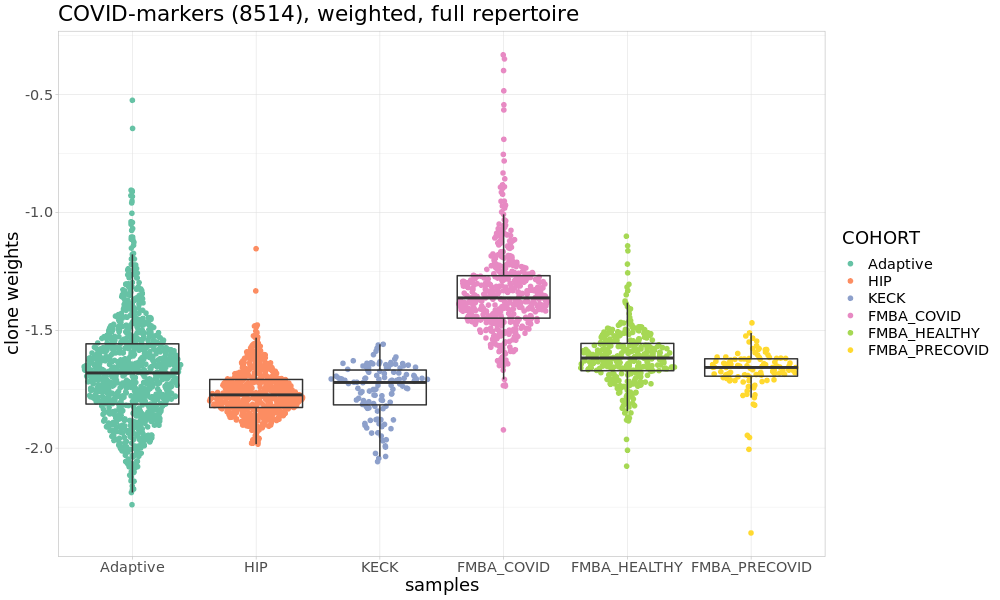

In [25]:
%%R  -w 1000 -h 600
#full repertoire
#weighted
#-----clones found by Wilcox test (8514) from public clones FMBA and Adaptive----- 
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_full_repertoire/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (8514), weighted, full repertoire")

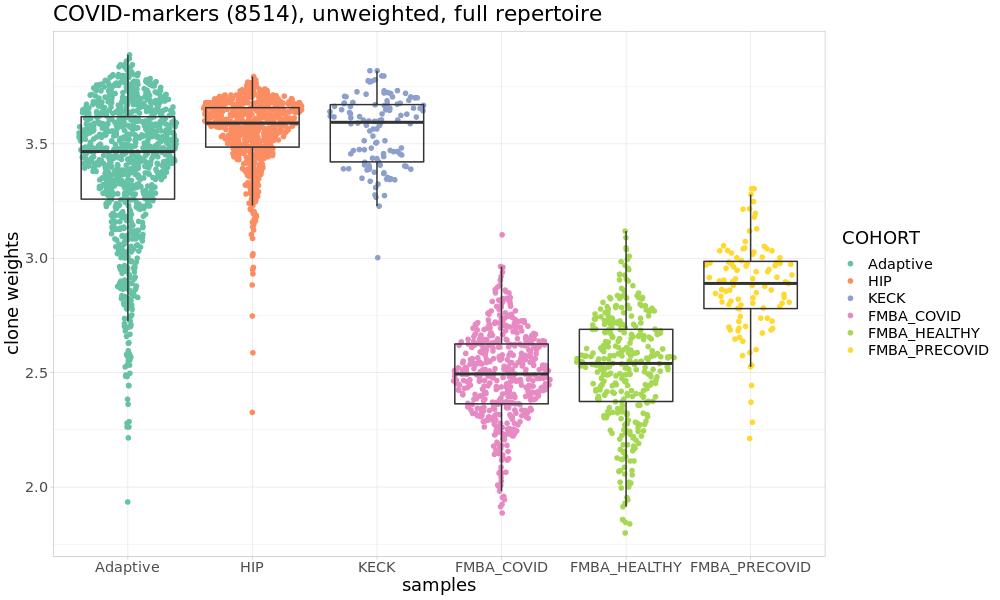

In [80]:
%%R  -w 1000 -h 600
#full repertoire
#unweighted
#-----clones found by Wilcox test (8514) from public clones FMBA and Adaptive----- 
data=read.csv('BOXPLOTS/UNWEIGHT/Adaptive_FMBA_full_repertoire/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (8514), unweighted, full repertoire")

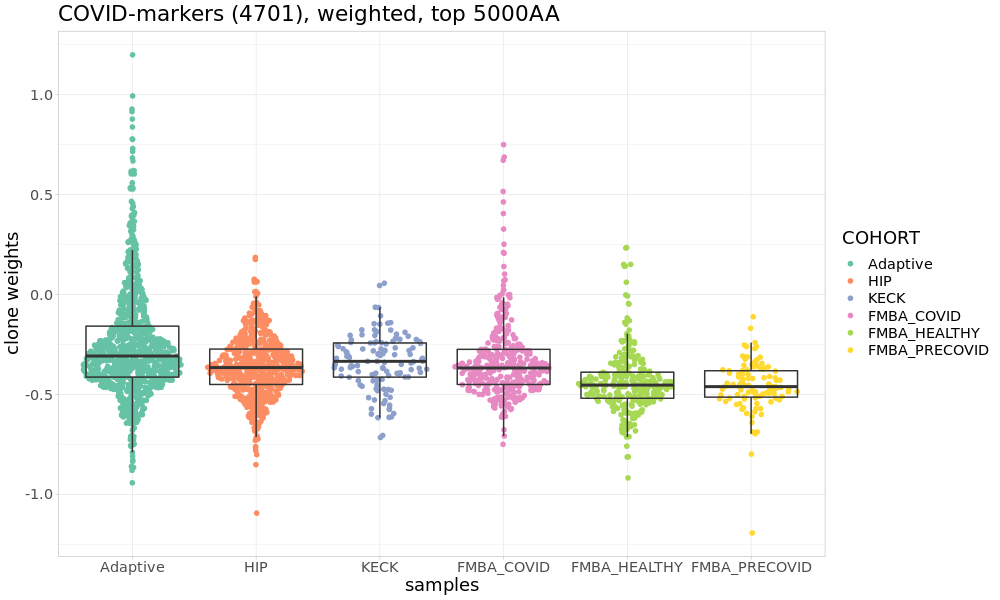

In [152]:
%%R  -w 1000 -h 600
#top 5000AA
#weighted
#-----clones found by Wilcox test (4701) from public clones FMBA and Adaptive----- 
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_top_5000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (4701), weighted, top 5000AA")

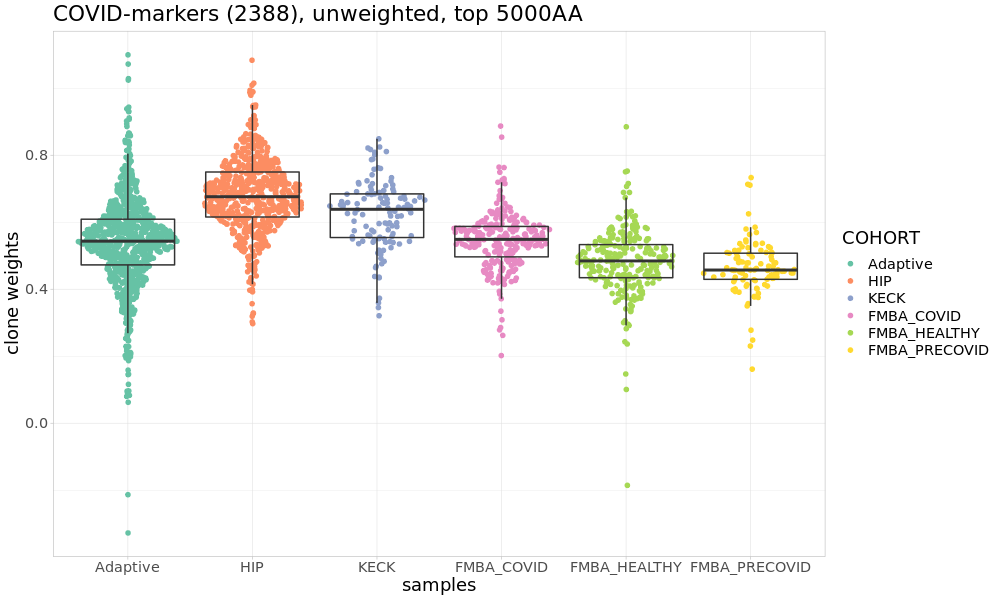

In [224]:
%%R  -w 1000 -h 600
#top 5000AA
#unweighted
#-----clones found by Wilcox test (2388) from public clones FMBA and Adaptive----- 
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (2388), unweighted, top 5000AA")

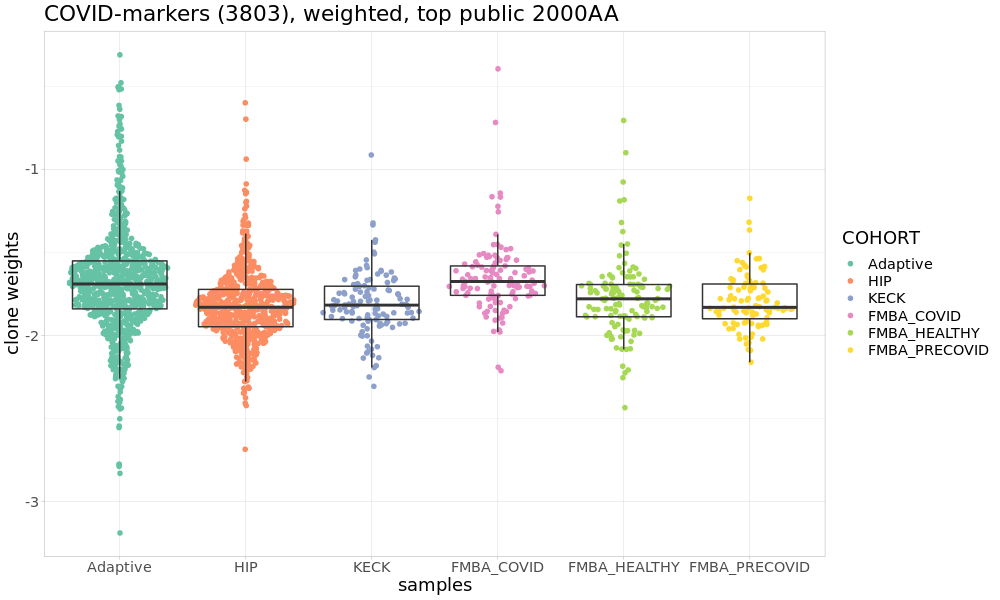

In [350]:
%%R  -w 1000 -h 600
#top public 2000AA
#weighted
#-----clones found by Wilcox test (3803) from public clones FMBA and Adaptive----- 
#from public clones incidence_AB>40; incidence_FMBA>30 take random 50000 clones 
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (3803), weighted, top public 2000AA")

In [89]:
pool_random_clones=random.sample(pool_filter_AB, 10000)

COVID_SUM=FMBA_AB_data[pool_random_clones].sum(axis=1).to_frame(name="WEIGHT_SUM")
COVID_SUM.loc[COVID_SUM.index.isin(Adaptive) , "COHORT"]="Adaptive"
COVID_SUM.loc[COVID_SUM.index.isin(HIP) , "COHORT"]="HIP"
COVID_SUM.loc[COVID_SUM.index.isin(KECK) , "COHORT"]="KECK"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_COVID) , "COHORT"]="FMBA_COVID"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_HEALTHY) , "COHORT"]="FMBA_HEALTHY"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_PRECOVID) , "COHORT"]="FMBA_PRECOVID"
COVID_SUM.to_csv("BOXPLOTS/Adaptive_FMBA_top_5000AA/random_pool_Adaptive_FMBA_public_AB.tsv", sep="\t")

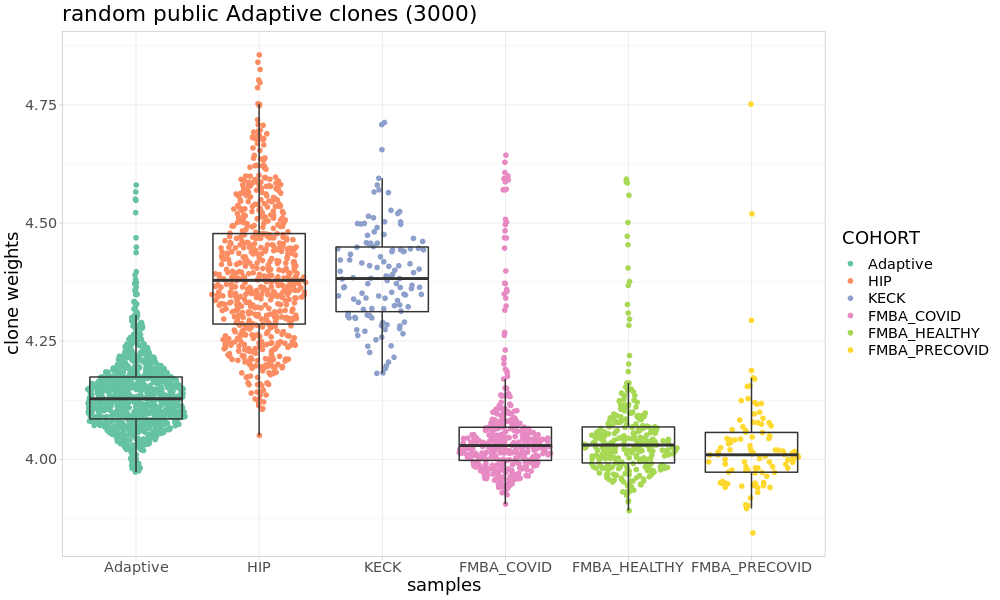

In [85]:
%%R  -w 1000 -h 600


#-----random public clones (3000) from public clones FMBA-----

data=read.csv('BOXPLOTS/Adaptive_FMBA_top_5000AA/random_pool_Adaptive_FMBA_public_AB.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("random public Adaptive clones (3000)")

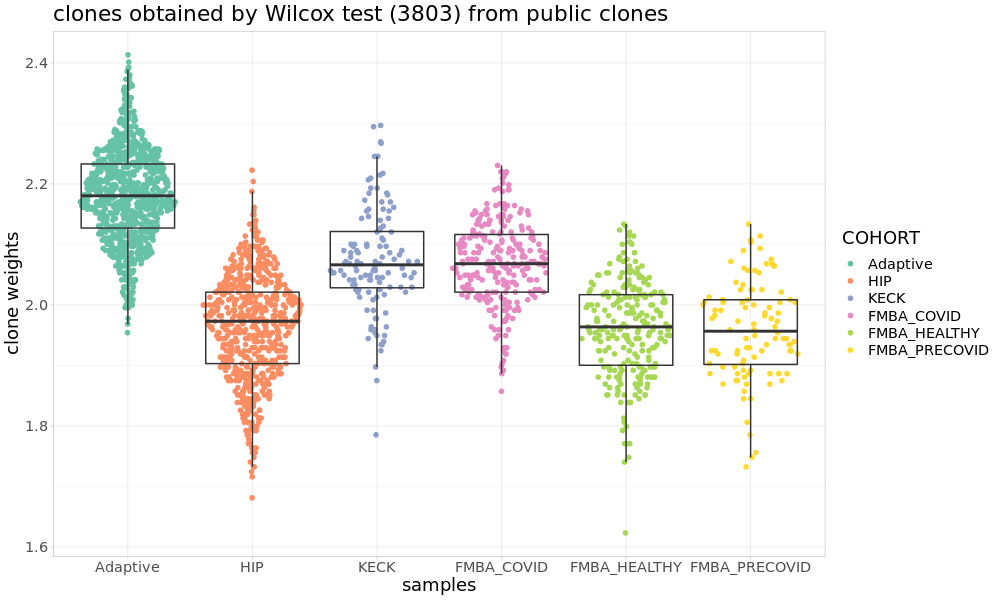

In [62]:
%%R  -w 1000 -h 600

#-----clones found by Wilcox test (3803) from public clones----- 
#-----top public clones 2000, complete sequence match, COVID markers (3803), categories-----
data=read.csv('BOXPLOTS/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_public.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("clones obtained by Wilcox test (3803) from public clones")

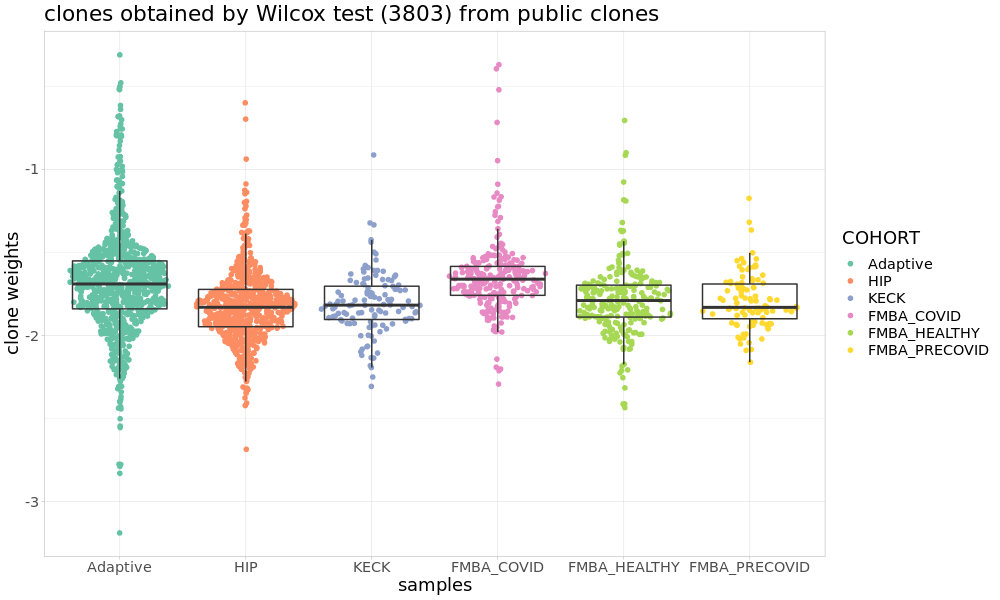

In [73]:
%%R  -w 1000 -h 600

#-----clones found by Wilcox test (3803) from public clones----- 
#-----top public clones 2000, complete sequence match, COVID markers (3803), freq
data=read.csv('BOXPLOTS/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("clones obtained by Wilcox test (3803) from public clones, top 2000 public")

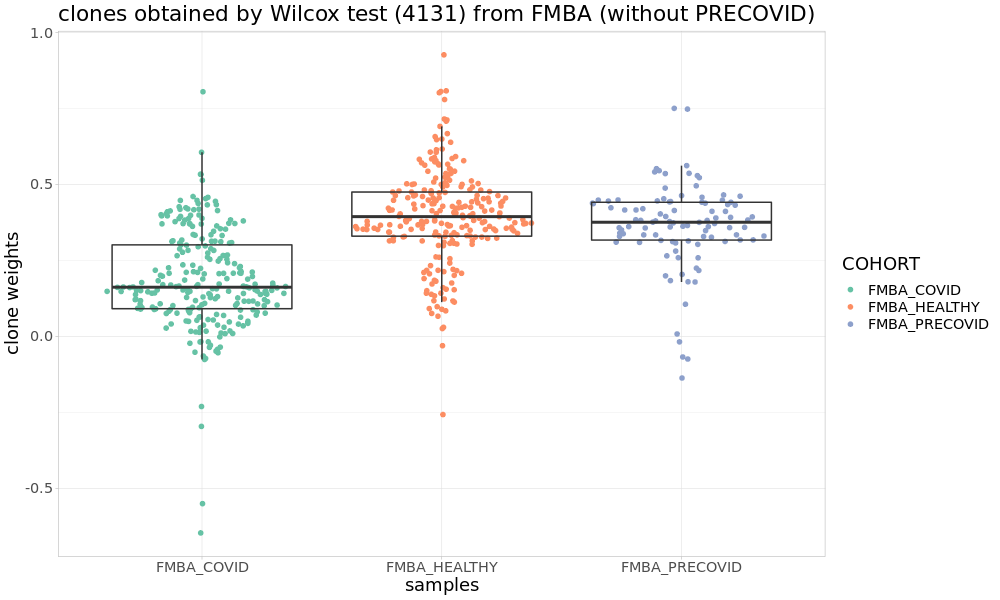

In [173]:
%%R  -w 1000 -h 600

#-----clones found by Wilcox test (4131) from public clones FMBA-----
data=read.csv('BOXPLOTS/FMBA_top_public_2000AA/FMBA_COVID_markers_without_precovid.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("clones obtained by Wilcox test (4131) from FMBA (without PRECOVID)")